<a href="https://colab.research.google.com/github/atharv946/Chromatin-Accessibility/blob/main/Step8a_Hybrid_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import pandas as pd

from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.optimizers import Adam

from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_train_random_1k.csv')
df_val = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_valid_random_1k.csv')
df_train_kmer = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_KMER_train_random_1k.csv')
df_val_kmer = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_KMER_val_random_1k.csv')

In [ ]:
# Function to one-hot encode a sequence
def one_hot_encode(sequence, max_length):

    encoding = {'A': [1, 0, 0, 0],

                'C': [0, 1, 0, 0],

                'G': [0, 0, 1, 0],

                'T': [0, 0, 0, 1],

                'N': [0, 0, 0, 0]

                }

    # One-hot encode the sequence
    encoded_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence[:max_length]]

    # Pad to the maximum length by adding [0, 0, 0, 0] (which represents 'N' or padding)
    return pad_sequences([encoded_sequence], maxlen=max_length, dtype='int32', padding='post')[0]

# New Section

In [ ]:
df_val_kmer.head(10)

,0,1,2,3,4,5,6,7,8,9,...,4223,4224,4225,4226,4227,4228,4229,4230,4231,accessibility
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,1,0,0,0,0,1,0,2,...,0,0,0,1,0,0,0,0,0,1.0
2,17,2,3,0,3,2,1,0,0,1,...,1,1,0,0,0,1,1,0,1,1.0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,15,1.0
4,7,0,2,0,1,0,0,0,0,2,...,0,1,0,0,3,3,0,3,11,1.0
5,0,1,1,0,0,0,2,0,1,3,...,0,0,0,0,0,0,0,0,0,0.0
6,1,1,0,0,1,0,0,1,1,0,...,2,3,0,0,3,3,0,5,10,0.0
7,3,0,1,0,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1.0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0.0


In [ ]:
# Set the fixed sequence length
fixed_length = 1000


# One-hot encode all sequences in the DataFrame and truncate/pad to fixed length
X_train = np.array([one_hot_encode(seq, fixed_length) for seq in df_train['sequence']])
X_train_kmer = df_train_kmer.iloc[:, :4000]

In [ ]:
y_train  = np.array(df_train['accessibility'])
y_reg_train = np.array(df_train['signalValue'])

In [ ]:
X_val = np.array([one_hot_encode(seq, fixed_length) for seq in df_val['sequence']])
X_val_kmer = df_val_kmer.iloc[:, :4000]

In [ ]:
y_val = np.array(df_val['accessibility'])
y_reg_val = np.array(df_val['signalValue'])

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models, Input

def create_hybrid_cnn_model(ohe_input_shape):

    # OHE Input layer
    ohe_inputs = Input(shape=(1000, 4, 1))
    kmer_inputs = Input(shape=X_train_kmer.shape[1:])


    # CNN Layers
    x = layers.Conv2D(filters=64, kernel_size=(13,4), activation='relu', padding='same')(ohe_inputs)
    x = layers.Conv2D(filters=64, kernel_size=(13,1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)
    # Add more CNN layers as needed
    x = layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)

    x = layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)

    x = layers.Flatten()(x)
    # x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=64, activation='relu')(x)
    # x = layers.Dense(units=32, activation='relu')(x)
    x = models.Model(inputs=ohe_inputs, outputs=x)

    #KMER FFNN
    y = layers.Dense(units=32, activation='relu')(kmer_inputs)
    # y = layers.Dense(units=32, activation='relu')(y)
    y = models.Model(inputs=kmer_inputs, outputs=y)

    z = layers.concatenate([x.output, y.output])
    z = layers.Dense(units=64, activation='relu')(z)


    # Reshape for Transformer compatibility
    #x = layers.Reshape(target_shape=(-1, 128))(x)
    # Transformer Block (using MultiHeadAttention)
    # The input here is reshaped to match the required shape for attention
    #attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    # Add a Dense layer to process attention output
    # x = layers.GlobalAveragePooling1D()(attention_output)
    z = layers.Dense(units=64, activation='relu')(z)


    # Classification Head=
    classification_output = layers.Dense(1, activation='sigmoid', name='classification_output')(z)

    regression_output = layers.Dense(1, activation='linear', name='regression_output')(z)


    # Model
    model = models.Model(inputs=[x.input, y.input], outputs=[classification_output, regression_output])

    return model

In [ ]:
# Define input shape according to your data
ohe_input_shape = X_train.shape[1:]

model = create_hybrid_cnn_model(ohe_input_shape)

# Compile the model
model.compile(

    optimizer = Adam(learning_rate=0.0001),
    loss={

        'classification_output': 'binary_crossentropy',

        'regression_output': 'mean_squared_error',

    },

    metrics={

        'classification_output': ['accuracy'],

        'regression_output': ['mse'],

    }

)
# Summary of the model
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1000, 4, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 1000, 4, 64)    │          3,392 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 1000, 4, 64)    │         53,312 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 200, 4, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 200, 4, 64)     │         28,736 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 200, 4, 64)     │         28,736 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 40, 4, 64)      │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 40, 4, 64)      │         20,544 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 40, 4, 64)      │         20,544 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 8, 4, 64)       │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2048)           │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 4000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │        131,136 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 32)             │        128,032 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 96)             │              0 │ dense_10[0][0],        │
│ (Concatenate)             │                        │                │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │          6,208 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)     

 Total params: 424,930 (1.62 MB)

 Trainable params: 424,930 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

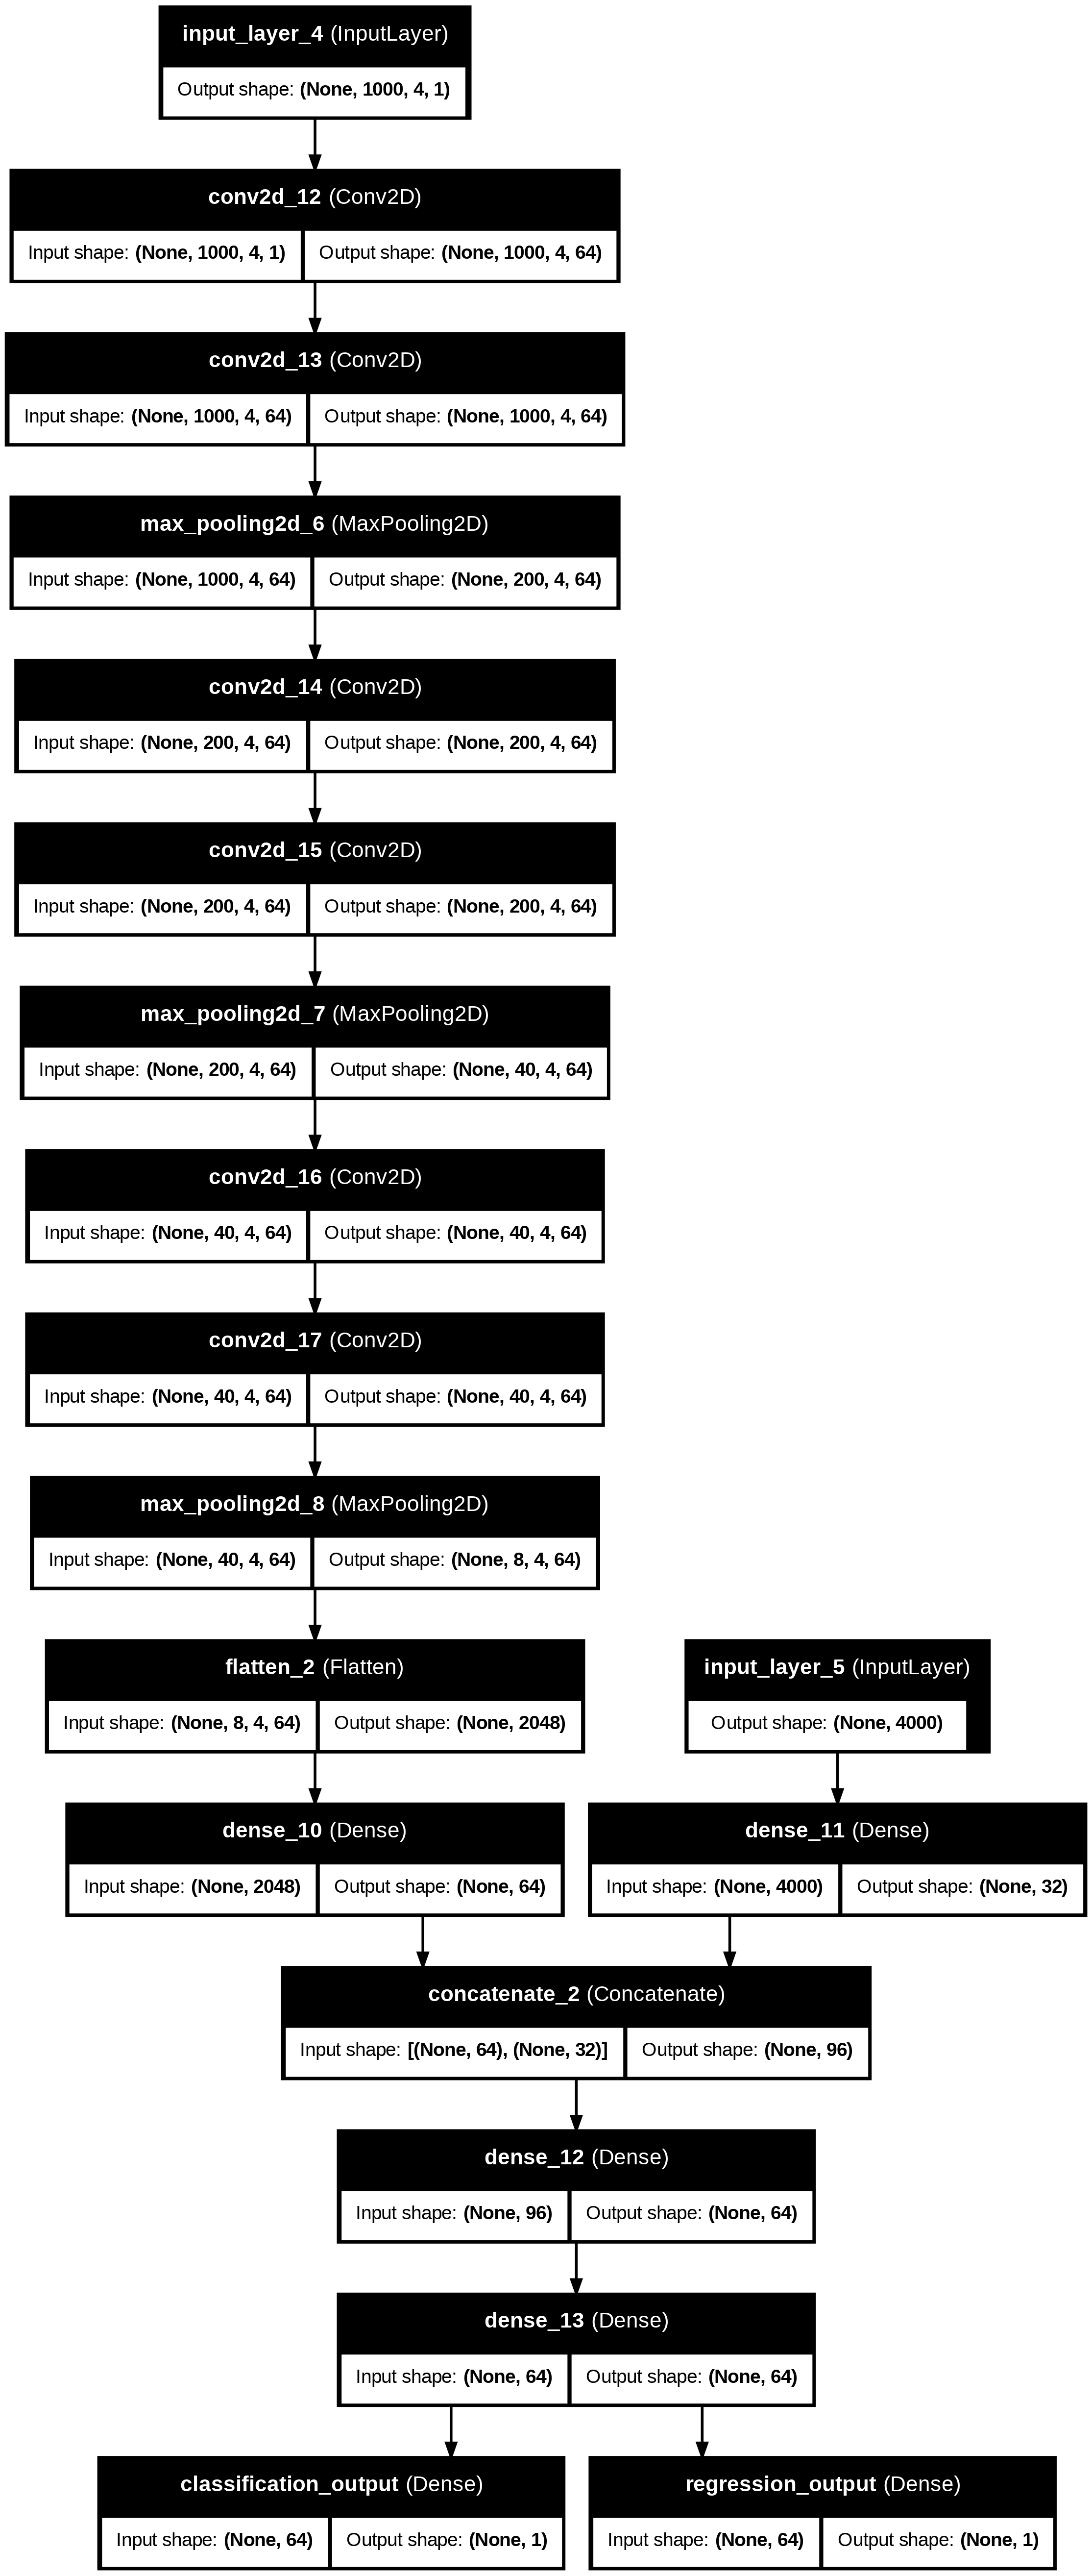

In [ ]:
plot_model(model, to_file='hybrid8a.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image('hybrid8a.png')

In [ ]:
model_trained = model.fit(

    [X_train, X_train_kmer],

    {'classification_output': y_train, 'regression_output': y_reg_train},

    validation_data=([X_val, X_val_kmer], {'classification_output': y_val, 'regression_output': y_reg_val}),

    epochs=10,  # Specify the number of epochs

    batch_size=2,  # Specify the batch size

    verbose=1  # Verbosity mode

)

Epoch 1/10
58266/58266 ━━━━━━━━━━━━━━━━━━━━ 203s 3ms/step - classification_output_accuracy: 0.7587 - classification_output_loss: 0.4691 - loss: 2.5532 - regression_output_loss: 2.0840 - regression_output_mse: 2.0840 - val_classification_output_accuracy: 0.8627 - val_classification_output_loss: 0.3174 - val_loss: 1.9182 - val_regression_output_loss: 1.6007 - val_regression_output_mse: 1.6008
Epoch 2/10
58266/58266 ━━━━━━━━━━━━━━━━━━━━ 200s 3ms/step - classification_output_accuracy: 0.8886 - classification_output_loss: 0.2670 - loss: 1.7994 - regression_output_loss: 1.5323 - regression_output_mse: 1.5323 - val_classification_output_accuracy: 0.8928 - val_classification_output_loss: 0.2589 - val_loss: 1.7508 - val_regression_output_loss: 1.4918 - val_regression_output_mse: 1.4919
Epoch 3/10
58266/58266 ━━━━━━━━━━━━━━━━━━━━ 199s 3ms/step - classification_output_accuracy: 0.9034 - classification_output_loss: 0.2356 - loss: 1.5308 - regression_output_loss: 1.2952 - regression_output_mse: 1.2

In [ ]:
import matplotlib.pyplot as plt

def plot_history(model):

    # Plot training & validation accuracy values

    plt.figure(figsize=(14, 5))

    # Accuracy subplot

    plt.subplot(1, 2, 1)

    plt.plot(model.history['classification_output_accuracy'], label='Train Accuracy')

    plt.plot(model.history['val_classification_output_accuracy'], label='Validation Accuracy')

    plt.title('Model Accuracy')

    plt.xlabel('Epoch')

    plt.ylabel('Accuracy')

    plt.legend(loc='upper left')


    # Loss subplot
    plt.subplot(1, 2, 2)

    plt.plot(model.history['loss'], label='Train Loss')

    plt.plot(model.history['val_loss'], label='Validation Loss')

    plt.title('Model Loss')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.legend(loc='upper left')

    plt.tight_layout()

    plt.show()

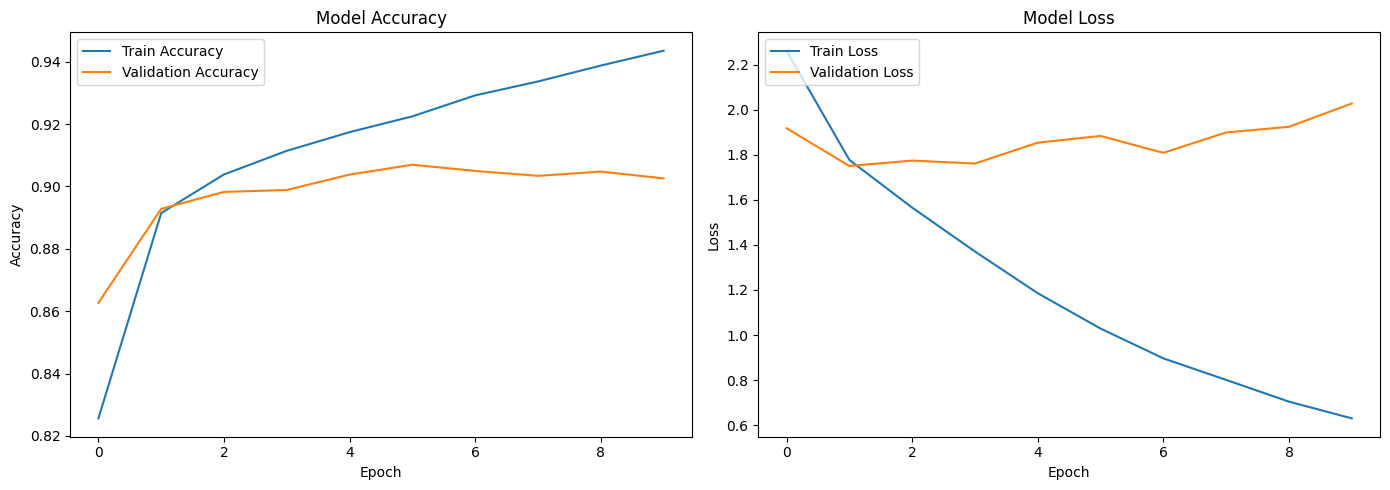

In [ ]:
plot_history(model_trained)

In [ ]:
# Evaluate the model on the test dataset
val_score = model.evaluate([X_val, X_val_kmer], y_val, verbose=1)

print(f'Accuracy on validation set: {val_score[1] * 100}%')

456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - classification_output_accuracy: 0.9025 - classification_output_loss: 0.2735 - loss: 0.2735 - regression_output_loss: 0.0000e+00 - regression_output_mse: 0.0000e+00
Accuracy on validation set: 27.66631841659546%


In [ ]:
# After finding optimized paramaters(learning rates and epochs) run this cell to save best model
model.save("/content/drive/MyDrive/1:1_Atharv_Gupta/Models/best_model_Hybrid_CNN.h5")

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_test_random_1k.csv')
df_test_kmer = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_KMER_test_random_1k.csv')
X_test = np.array([one_hot_encode(seq, fixed_length) for seq in df_test['sequence']])
X_test_kmer = df_test_kmer.iloc[:, :4000]
y_test  = np.array(df_test['accessibility'])
y_reg_test = np.array(df_test['signalValue'])

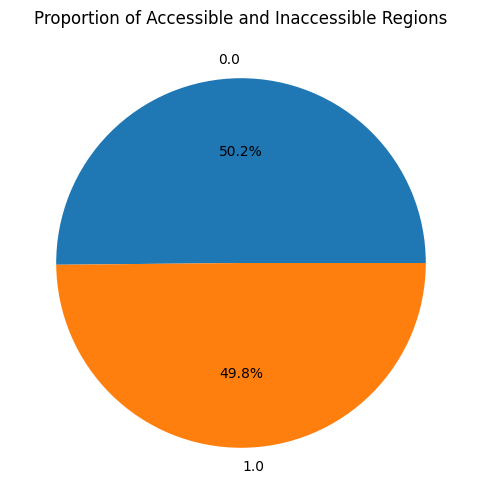

In [ ]:
import matplotlib.pyplot as plt

accessibility_counts = df_test['accessibility'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(accessibility_counts, labels=accessibility_counts.index, autopct='%1.1f%%')
_ = plt.title('Proportion of Accessible and Inaccessible Regions')



In [ ]:
test_accuracy = model.evaluate([X_test, X_test_kmer], y_test, verbose=1)

y_pred_probs, y_pred_signal = model.predict([X_test, X_test_kmer])

#y_pred = np.argmax(y_pred_probs, axis=-1)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 0.9112 - classification_output_loss: 0.2635 - loss: 0.2635 - regression_output_loss: 0.0000e+00 - regression_output_mse: 0.0000e+00
456/456 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_pred

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

Classification Report:
              precision    recall  f1-score   support

Inaccessible       0.91      0.91      0.91      7306
  Accessible       0.91      0.91      0.91      7261

    accuracy                           0.91     14567
   macro avg       0.91      0.91      0.91     14567
weighted avg       0.91      0.91      0.91     14567



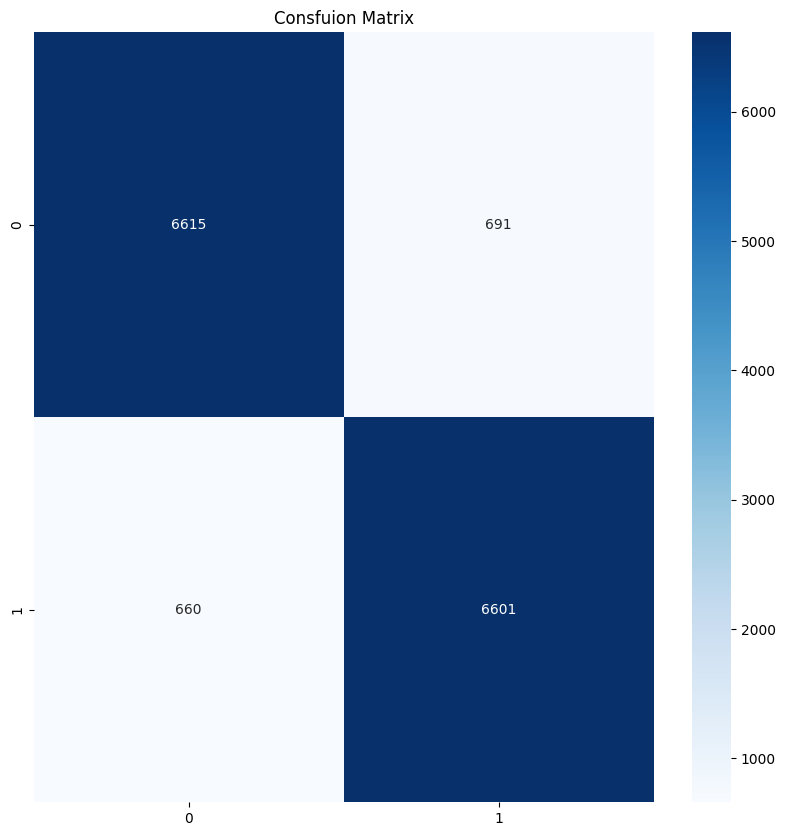

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate classification report
print("Classification Report:")
class_names = ['Inaccessible','Accessible']
print(classification_report(y_test, y_pred, target_names=class_names))
model_evaluation = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test, y_pred),  annot = True, fmt="g", cmap = "Blues")
plt.title("Consfuion Matrix")
plt.show()